                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4967.89
Distribution:                  Normal   AIC:                           9943.77
Method:            Maximum Likelihood   BIC:                           9966.96
                                        No. Observations:                 2432
Date:                Tue, Nov 05 2024   Df Residuals:                     2431
Time:                        21:47:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.4265e-03  3.241e-02      0.260      0.795 

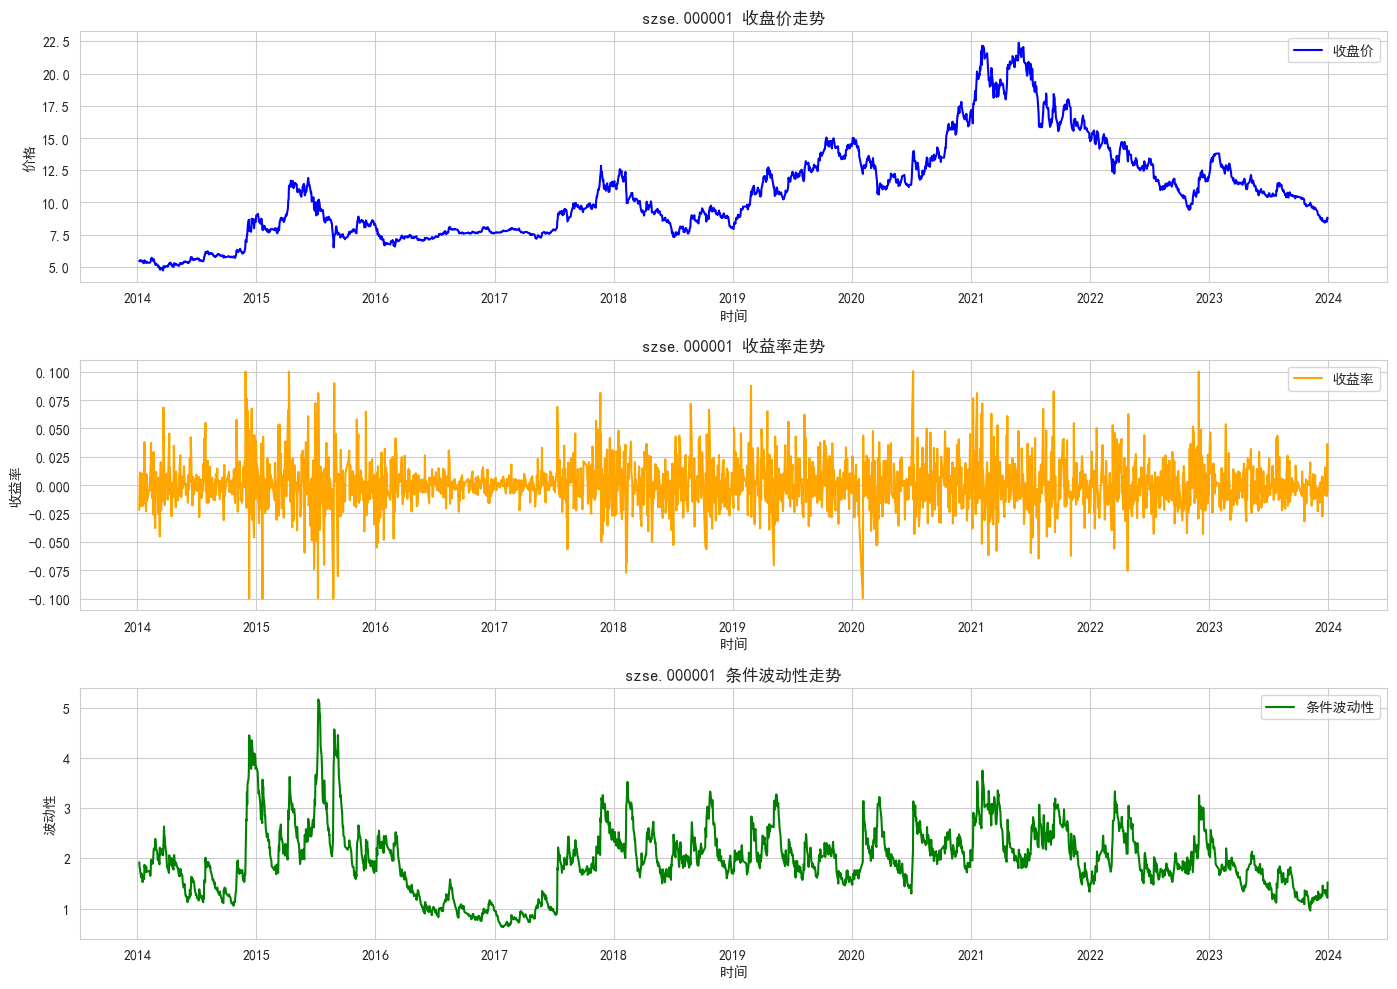

In [1]:
import pandas as pd
import os
from arch import arch_model
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义文件夹路径
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'

# 创建字典存储股票相关信息数据
market_info = {}
# 读取 market_info 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_{year}.csv'  # 文件名格式
    file_path = os.path.join(info_folder, file_name)
    if os.path.isfile(file_path):  # 检查文件是否存在
        data = pd.read_csv(file_path)  # 默认读取，自动检测标题
        market_info[f'year_{year}'] = data  # 存储数据到字典中
    else:
        print(f'Warning: File {file_path} does not exist.')

# 创建字典存储股票具体数据
market_data = {}
# 读取 market_data 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_kdata_{year}.csv'  # 文件名格式
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path):  # 检查文件是否存在
        data = pd.read_csv(file_path)  # 默认读取，自动检测标题
        market_data[f'year_{year}'] = data  # 存储数据到字典中
    else:
        print(f'Warning: File {file_path} does not exist.')

# 合并所有年份的市场数据为一个数据框
combined_market_data = pd.concat(market_data.values(), ignore_index=True)

# 选择一个特定的股票代码进行分析
stock_code = 'szse.000001'
stock_data = combined_market_data[combined_market_data['code'] == stock_code].copy()  # 使用 .copy() 创建副本

# 确保时间列为 datetime 类型，指定格式
stock_data['time'] = pd.to_datetime(stock_data['time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
stock_data = stock_data.sort_values('time')

# 计算收益率
stock_data['return'] = stock_data['close'].pct_change()

# 去掉缺失值
stock_data = stock_data.dropna(subset=['time', 'close', 'return'])

# 缩放收益率
returns_scaled = stock_data['return'] * 100  # 缩放到适合的范围

# 拟合EGARCH模型（确保使用缩放后的收益率）
model = arch_model(returns_scaled, vol='EGARCH', p=1, q=1)
model_fit = model.fit(disp='off')  # 关闭输出

# 输出模型参数
print(model_fit.summary())

# 提取条件波动性
conditional_volatility = model_fit.conditional_volatility

# 将条件波动性添加到原始数据中
# 注意这里的索引要对齐
stock_data['conditional_volatility'] = pd.Series(conditional_volatility, index=stock_data.index[1:])

# 确保没有缺失值
stock_data = stock_data.dropna(subset=['conditional_volatility'])

# 可视化
plt.figure(figsize=(14, 10))

# 绘制股票价格
plt.subplot(3, 1, 1)
sns.lineplot(x=stock_data['time'], y=stock_data['close'], label='收盘价', color='blue')
plt.title(f'{stock_code} 收盘价走势')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()

# 绘制收益率
plt.subplot(3, 1, 2)
sns.lineplot(x=stock_data['time'], y=stock_data['return'], label='收益率', color='orange')
plt.title(f'{stock_code} 收益率走势')
plt.xlabel('时间')
plt.ylabel('收益率')
plt.legend()

# 绘制条件波动性
plt.subplot(3, 1, 3)
sns.lineplot(x=stock_data['time'][1:], y=stock_data['conditional_volatility'][1:], label='条件波动性', color='green')
plt.title(f'{stock_code} 条件波动性走势')
plt.xlabel('时间')
plt.ylabel('波动性')
plt.legend()

# 调整布局
plt.tight_layout()
plt.show()
